  # CÁLCULO DE LAS FUNCIONES EMPÍRICAS ORTOGONALES /COMPONENTES PRINCIPALES

## Este cuaderno te guía a la hora de saber cómo calcular en python las componentes principales, las funciones empíricas ortogonales, analizar los modos de variabilidad y reconstruir un campo 

Vamos a trabajar con el Ejemplo la Oscilación del Atlántico Norte y con datos de 100 años de ERA20. La metodología de este ejemplo te puede servir para el resto de ejercicios de la Práctica 3.


In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.fft import fft 
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import numpy.ma as ma
import numpy.linalg as linalg
import time


En este cuaderno de Jupyter haremos una revisión del cálculo de la matriz de covarianza, su diagonalización y determinación de autovalores y autovectores


    numpy: para hacer cálculos sobre los datos
    pyplot: para dibujar
    stats de scipy: para alguna métrica estadística y también para el manejo de filtros y transformadas
    Dataset de netCDF: para la lectura de datos en formato netcdf
    De cartopy usamos función add_cyclic_point (para poder pintar la longitud como un continuo)
    De cartopy importmos el módulo ccrs para poder usar diferentes proyecciones
    Importamos time para poder hacer una movie

Lo primero que hay que hacer es leer los datos

In [4]:
#indica el path donde tienes los datos
path=r"C:/Users/Portatil/Desktop/Analisis_de_datos_en_meteorologia/Practica_3_entregar/"
#path='/users/imac/belen/python_curso_analisisdatos/analisis_multivariante/datos/'
vari =r'slp_ERA20_1900-2010 .nc'


### Para poder leer correctamente un netcdf tienes que leerlo con nc.Dataset y con .variables (sin ningun argumento de entrada) lo que haces es ver los nombres y características de TODAS variables que tiene el fichero netcdf

In [5]:
fil = nc.Dataset(path + vari)
myvar = fil.variables
myvar

{'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(longitude)
     units: degrees_east
     long_name: longitude
 unlimited dimensions: 
 current shape = (360,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     units: degrees_north
     long_name: latitude
 unlimited dimensions: 
 current shape = (181,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     units: hours since 1900-01-01 00:00:0.0
     long_name: time
     calendar: gregorian
 unlimited dimensions: time
 current shape = (1332,)
 filling on, default _FillValue of -2147483647 used,
 'msl': <class 'netCDF4._netCDF4.Variable'>
 int16 msl(time, latitude, longitude)
     scale_factor: 0.14532849861901637
     add_offset: 100539.70858575069
     _FillValue: -32767
     missing_value: -32767
     units: Pa
     long_name: Mean sea level press

### Al ejecutar la línea anterior, vemos que los datos de la variable 'msl' se encuentran organizados en (tiempo, latitudes, longitudes)


## Recordemos el esquema de funcionamiento que hemos dado en clase
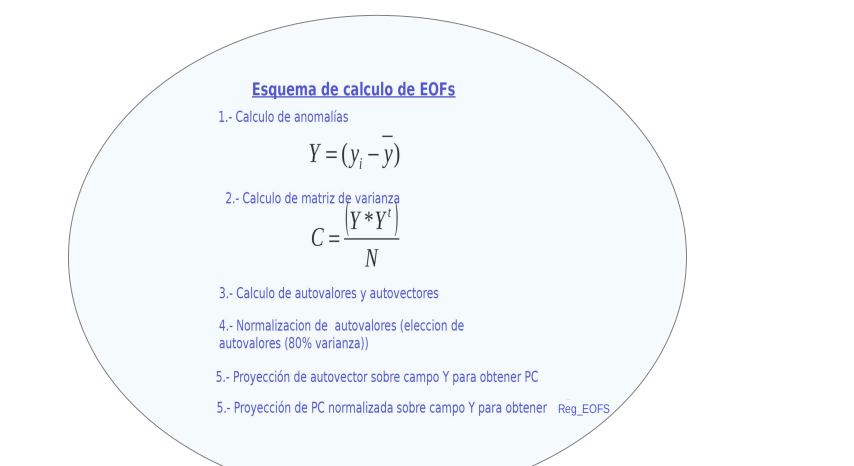

 # Paso 1. Determinación de anomalías
 1) Determinación de la región de estudio 
 2) Determinación de la media temporal
 3) Determinación de las anomalias 


###  Vamos a leer los datos y recortar la region

como tienen mucha resolución y el cálculo de la matriz de covarianza usa mucha RAM, vamos a coger a modo de ejemplo una region del Atlantico Norte.
Si se calcula sobre todo el Atlantico Norte será más realista y representará el Modo Anular del Hemisferio Norte

In [6]:
lon = fil.variables['longitude'][:]
lat = fil.variables['latitude'][:]
SLP = fil.variables['msl'][:]

nt, nlat, nlon = SLP.shape
nm = 12
nyears = int(nt/nm)
lonmin,lonmax,latmin,latmax = 260, 360, 10, 75
ATN = SLP[:,:,(lon>lonmin)&(lon<lonmax)][:,(lat>latmin)&(lat<latmax),:]
yrs = np.arange(1900,2011)
lon_ATN= lon[(lon>lonmin)&(lon<lonmax)]
lat_ATN=lat[(lat>latmin)&(lat<latmax)]

<ipython-input-6-5bb1665ea6f3>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = fil.variables['longitude'][:]
<ipython-input-6-5bb1665ea6f3>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = fil.variables['latitude'][:]
<ipython-input-6-5bb1665ea6f3>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silenc

In [7]:
SLP.shape

(1332, 181, 360)

In [8]:
yrs=nt/nm
yrs

111.0

In [9]:
nt,nlat2,nlon2=ATN.shape

In [10]:
ATN.shape

(1332, 64, 99)

In [11]:
lon_ATN

masked_array(data=[261., 262., 263., 264., 265., 266., 267., 268., 269.,
                   270., 271., 272., 273., 274., 275., 276., 277., 278.,
                   279., 280., 281., 282., 283., 284., 285., 286., 287.,
                   288., 289., 290., 291., 292., 293., 294., 295., 296.,
                   297., 298., 299., 300., 301., 302., 303., 304., 305.,
                   306., 307., 308., 309., 310., 311., 312., 313., 314.,
                   315., 316., 317., 318., 319., 320., 321., 322., 323.,
                   324., 325., 326., 327., 328., 329., 330., 331., 332.,
                   333., 334., 335., 336., 337., 338., 339., 340., 341.,
                   342., 343., 344., 345., 346., 347., 348., 349., 350.,
                   351., 352., 353., 354., 355., 356., 357., 358., 359.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

## vamos a calcular la media de enero y sustraerla


In [12]:
ATN_e=ATN.reshape(nyears,nm,nlat2*nlon2)[:,[0],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
ATN_e=(ATN_e-ATN_e.mean(0))
ATN_e.shape

(111, 6336)

# Fíjate que en todo momento consulto las dimensiones de las matrices resultantes. Es importante dimensionar bien

Text(0.5, 1.0, 'SLP enero 1900 hPa')

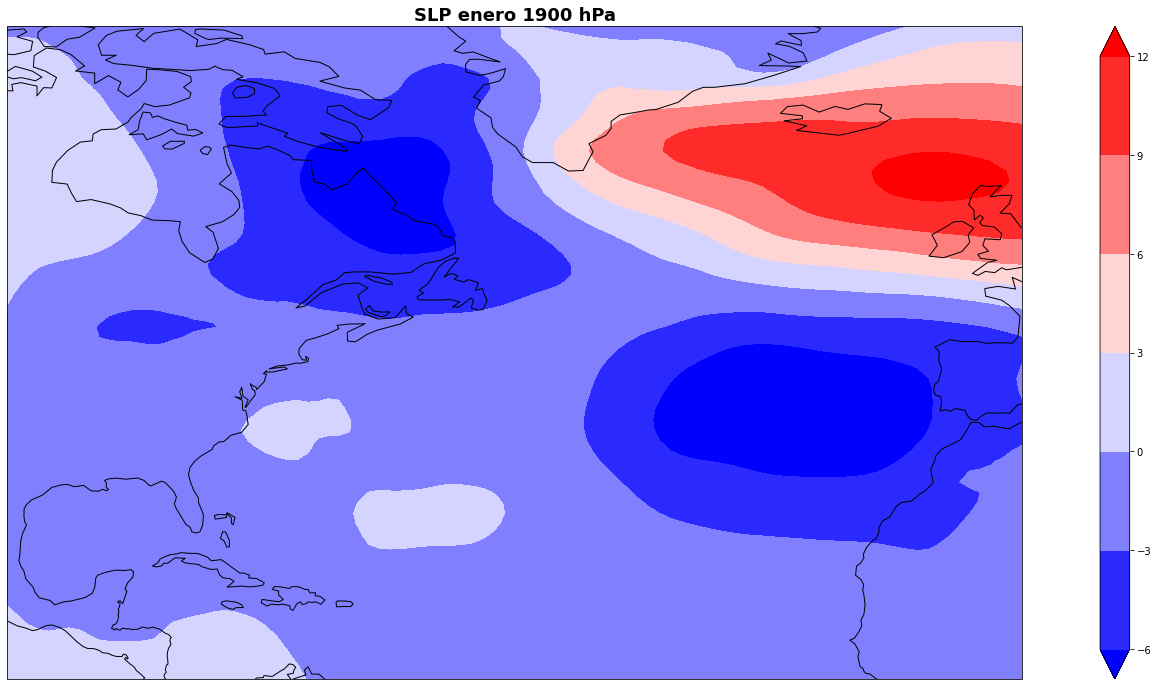

In [13]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_ATN,lat_ATN,ATN_e[97,:].reshape(len(lat_ATN),len(lon_ATN))/100,cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('SLP enero 1900 hPa',fontsize=18,weight='bold')


# Paso 2. Calculo de la matriz de covarianza

comprueba que calculas la covarianza temporal (espacio, espacio)

In [26]:
C=np.dot(np.transpose(ATN_e),ATN_e)

In [27]:
C.shape

(6336, 6336)

se trata de una matriz muy grande, por lo que en el siguiente paso diagonalizamos

# Paso 3: Diagonalización de Matriz de Covarianza. Cálculo de Autovalores y Autovectores

In [28]:
eof,d,eof2=linalg.svd(C)

In [29]:
d.shape

(6336,)

In [31]:
fvar=(d)/sum(d)

sum(fvar[:3])

0.7778787319364819

Vemos que con 10 autovalores ya explicamos casi el 96% de la variabilidad

### A continuación, dibujamos los  primeros 10 autovalores

<ipython-input-32-dd75dfae6b13>:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(fvar[:10],color='Blue',Marker='o',label='Evolucion de autovalores')


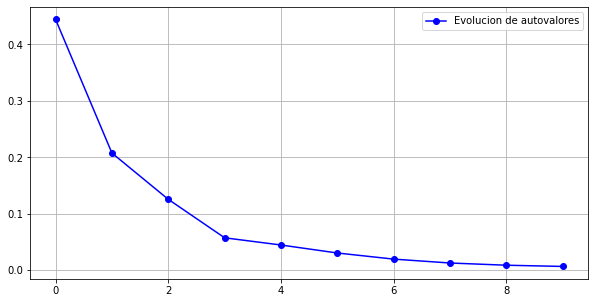

In [32]:
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(fvar[:10],color='Blue',Marker='o',label='Evolucion de autovalores')
plt.legend()
plt.grid()


# Paso 4. Calculo de las Componentes Principales y EOF en función de mapas e regresión

### Ahora tenemos que hacer la regresión de la EOF sobre los datos de la matriz de ATN_e
Recuerda que teníamos primero que calcular las componentes principales empleando esta fórmula
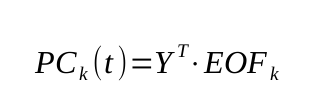

In [33]:
#Y había que transponerla si originariamente era (espacio, tiempo), pero ATN_e es (tiempo, espacio) así 
#que no se transpone
PC=np.dot(ATN_e,eof[:,:3])
#calculamos las anomalías estandarizadas 


In [34]:
PC.shape

(111, 3)

### ahora estandarizamos la PC
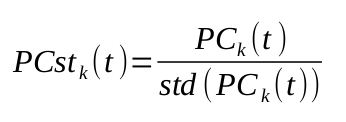

In [35]:
PCs=PC/np.std(PC)

### Elije el modo que quieres analizar

In [36]:
modo =1 
PC1s=PCs[:,modo]
PC1s.shape

(111,)

Text(0.5, 1.0, 'Primera componente principal fvar=')

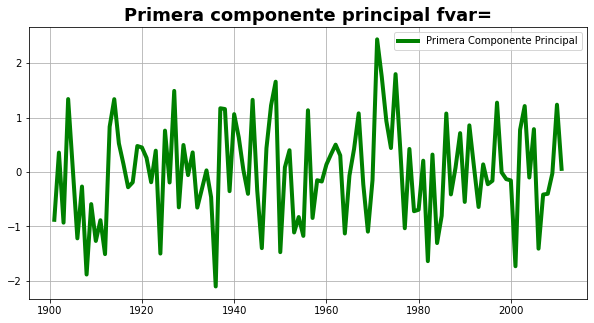

In [37]:
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1901,2012),PC1s,linewidth= 4,color='green',label='Primera Componente Principal')
ax.grid()
ax.legend()
ax.set_title('Primera componente principal fvar=',fontsize=18,weight='bold')


Se puede ver cierta tendencia y algo de variabilidad decadal, pero vamos a dejarlo así por ahora 

# Paso 5. Calculo del mapa de regresion para representar la EOF
Apliquemos ahora esta fórmula
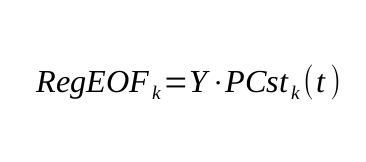

Para ellos acordemonos de la funcion IndexRegression

In [38]:
#FUNCIÓN PARA HACER LA CORRELACIÓN ESPACIAL, ES DECIR UN ÍNDICE CON UN MAPA,
#AUNQUE PODRÍA SER TAMBIÉN ENTRE DOS INDICES PARA n1=1
def IndexRegression(Data,Index,alfa):
    [n1,n2]=Data.shape #los datos introducidos en Data tienen que tener dimesión n1=espacio, n2=tiempo 
    #inicializamos las matrices
    Cor=ma.empty([n1,])
    Pvalue=ma.empty([n1,])
    reg=ma.empty([n1,])
    reg_sig=ma.empty([n1,])
    for nn in range(n1): #para cada punto del espacio hacemos la correlación de Pearson
        bb=pearsonr(Data[nn,:],Index) #bb tiene dos salidas: la primera es corre y la segunda es p-value 
        Cor[nn]=bb[0]
        Pvalue[nn]=bb[1]
    #generamos una variable que es para que no se muestren mas que los valores de Cor cuando la correlacion
    #es significativa
    Cor_sig=ma.masked_where(Pvalue>alfa,Cor)
    #generamos el mapa de regresión mediante multiplicación matricial. Ojo con las dimensiones!!
    reg=Data.dot(Index)/ (n2-1)
    #igualmente, hacemos una máscara para que sólo se muestre el mapa de regresión cuando es significativo
    reg_sig=ma.masked_where(Pvalue>alfa,reg)
    return Cor,Pvalue,Cor_sig,reg,reg_sig

In [39]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(ATN_e),np.transpose(PC1s),0.01)

# Paso 6. Dibujo la EOF 1 en forma de mapa de regresion significativo

Text(0.5, 1.0, 'Regresion de la PC1 ')

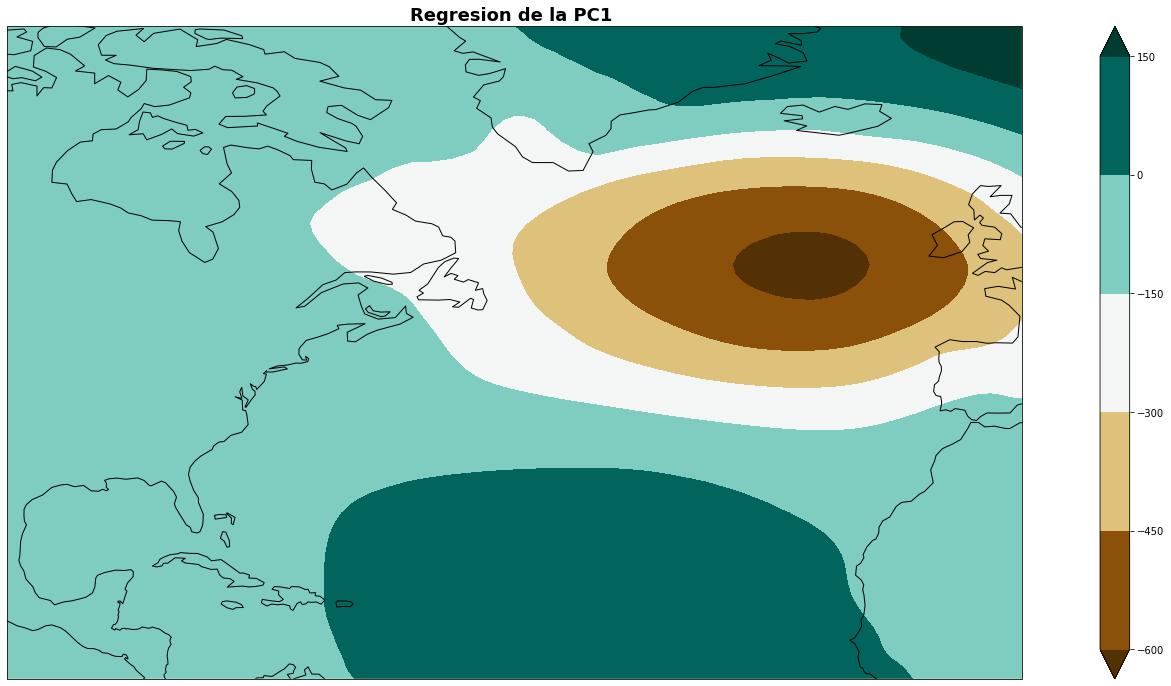

In [58]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_ATN,lat_ATN,regEOF.reshape(len(lat_ATN),len(lon_ATN)),cmap='BrBG',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Regresion de la PC1 ',fontsize=18,weight='bold')


#### Imaginaros que hubiera una gran tendencia. La idea es  quitar esa tendencia restando la resta de regresion

### Es interesante también distinguir entre la variabilidad de alta y baja frecuencia.  En este caso podéis también filtrar las PCs y ver sus componentes

En el Tema4 habéis visto diferentes filtros , sus ventajas y sus inconvenientes. 
Vamos a usar el filtro de Butterworth recordando que la frecuencia de corte se define como fc=dT/T siendo 
dt el intervalo de muestreo y T el periodo que queremos filtrar en las mismas unidades que  dt.
El filtro de Butter tiene la frecuencia normalizada con 1 correspondiendo a fmax=FNyquist
por tanto  Wn=fc*2
Tomamos n = 10 como orden nominal del filtro
Portanto, si quieremos aplicar un filtro de 12 años con datos equiespaciados 1 año (dt=1), tendremos que hacer
wn=2*dt/T=2*1/12=1/6;


In [59]:
nyc=12
n=10
Wn=1/6
b,a=signal.butter(n, Wn, btype='low', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
low = signal.filtfilt(b,a,PC1s)

b,a=signal.butter(n, Wn, btype='high', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
high = signal.filtfilt(b,a,PC1s)

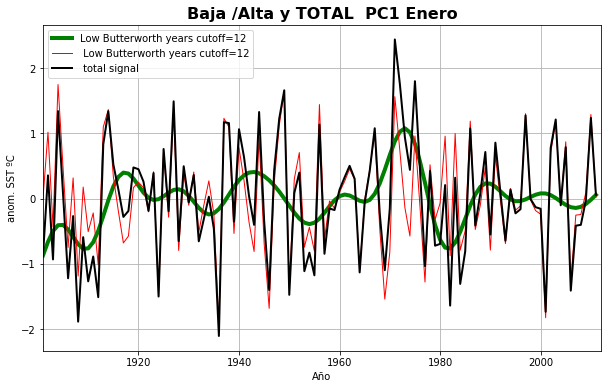

In [60]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Baja /Alta y TOTAL  PC1 Enero',fontsize=16,weight='bold')
ax.set_xlabel('Año')
ax.set_ylabel('anom. SST ºC')
ax.plot(range(1901,2012),low,linewidth= 4,color='green',label='Low Butterworth years cutoff='+str(nyc))
ax.plot(range(1901,2012),high,linewidth= 1,color='red',label=' Low Butterworth years cutoff='+str(nyc))
ax.plot(range(1901,2012),PC1s,linewidth= 2,color='black',label=' total signal')
ax.set_xlim([1901,2012])
ax.legend()
ax.grid()

# Reconstrucción del Campo

Hemos visto en clase que, conociendo las componentes podemos reconstruir la variabilidad con la siguiente expresión:
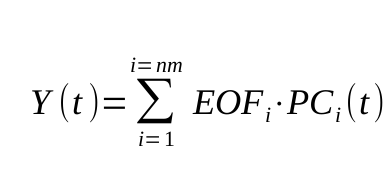

### Reconstrucción de ATN_e en enero de 1996


In [61]:
Y=ATN_e[yrs==1996]


Text(0.5, 1.0, 'SLP 1996')

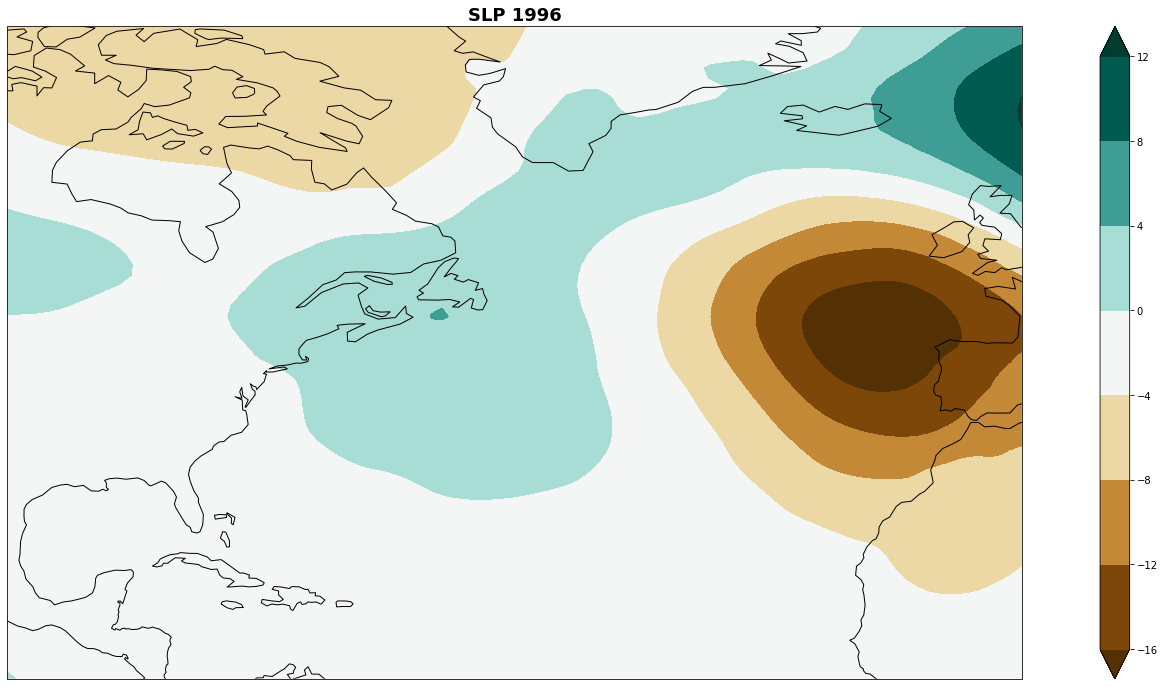

In [62]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_ATN,lat_ATN,Y.reshape(len(lat_ATN),len(lon_ATN))/100,cmap='BrBG',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('SLP 1996',fontsize=18,weight='bold')

## Reconstruimos con 1 modo

In [63]:
regEOF.shape


(6336,)

In [66]:
Yreconst=regEOF*PC1s[yrs==1996]

### ahora dibujamos el campo reconstruido

Text(0.5, 1.0, 'SLP 1996 reconstruida con PC1')

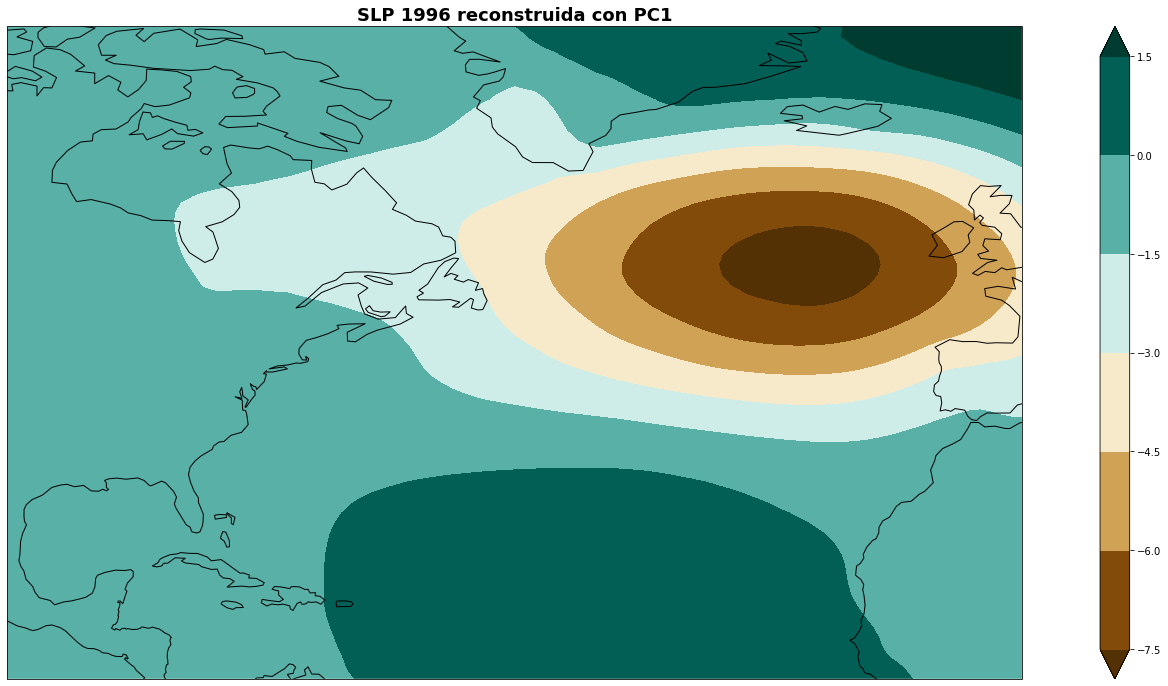

In [68]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_ATN,lat_ATN,Yreconst.reshape(len(lat_ATN),len(lon_ATN))/100,cmap='BrBG',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('SLP 1996 reconstruida con PC1',fontsize=18,weight='bold')